# 시나리오

### 웹 스크래핑, 크롤러
- 분단위 평균 기록횟수를 훌쩍 넘어가는 특정 시간대를 추출하여 리스팅
- 추출된 특정 시간대에서 사용된 UA 중 특수한 UA가 있는지 추출
- 추출된 특정 시간대에서 일반적인 접속량을 훌쩍 넘기는 Host 추출하여 리스팅
- 추출된 10개 Host의 패턴 분석 (Referer, Path, Bytes, 머무는 시간 등)
- 발견된 패턴대로 다른 Host에 대입하여 웹 스크래핑 입증

### 부르탈 포스, 크루덴셜 스터핑
- 

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../dataset/track1.csv')
df.Timestamp = pd.to_datetime(df.Timestamp)

## 시계열 데이터를 1분 단위로 설정

In [3]:
df['Timestamp'] = df['Timestamp'].dt.strftime('%Y-%m-%d %H:%M')

In [4]:
df.head()

,Timestamp,Method,Protocol,Status,Referer,Path,Host,UA,Payload,Bytes
0,2020-08-24 10:00,GET,HTTP/1.1,200,"""-""",/1000/wp-includes/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6226.0
1,2020-08-24 10:00,GET,HTTP/1.1,200,"""-""",/1000/wp-login/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6226.0
2,2020-08-24 10:00,GET,HTTP/1.1,200,"""-""",/1000/wp-register/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6232.0
3,2020-08-24 10:00,GET,HTTP/1.1,200,"""-""",/1000/wp/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6248.0
4,2020-08-24 10:00,GET,HTTP/1.1,200,"""-""",/1000/wp-content/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6224.0


## 이상치 제거

In [5]:
df = df.loc[df.Status.astype(str).str.isnumeric()].copy()

## 시간별로 Groupby 묶기
- 총 3822분간 기록된 로그
- 각 1분동안 진행된 모든 접근에 대하여 아래와 같은 그룹으로 나눕니다.
    - 그룹 A : 최대 접근 구간 (3000번 이상)
    - 그룹 B : 중간 접근 구간 (3000번 이하 ~ 2000번 이상)
    - 그룹 C : 최하 접근 구간 (2000번 이하)

In [3]:
time_grp = df.groupby(['Timestamp', 'Host'])

NameError: name 'df' is not defined

In [132]:
time_grp.count().head(13)

Method  Protocol  Status  Referer  Path  UA  \
Timestamp        Host                                                           
2020-08-24 10:00 101.224.32.28         9         9       9        9     9   9   
2020-08-24 10:01 101.224.32.28         3         3       3        3     3   3   
                 119.188.191.73        1         1       1        1     1   1   
                 149.148.142.101       1         1       1        1     1   1   
                 149.226.49.1          1         1       1        1     1   1   
                 210.128.88.9          1         1       1        1     1   1   
                 25.235.106.214        1         1       1        1     1   1   
                 44.103.170.136        1         1       1        1     1   1   
                 6.243.131.98          1         1       1        1     1   1   
                 73.208.36.92          1         1       1        1     1   1   
2020-08-24 10:02 101.224.32.28         7         7       7        7     7   7   
                 117.33.64.195         1         1       1        1     1   1   
                 119.188.191.73        1         1       1        1     1   1   

                                  Payload  Bytes  
Timestamp        Host                             
2020-08-24 10:00 101.224.32.28          9      9  
2020-08-24 10:01 101.224.32.28          3      3  
                 119.188.191.73         1      1  
                 149.148.142.101        1      1  
                 149.226.49.1           1      1  
                 210.128.88.9           1      1  
                 25.235.106.214         1      1  
                 44.103.170.136         1      1  
                 6.243.131.98           1      1  
                 73.208.36.92           1      1  
2020-08-24 10:02 101.224.32.28          7      7  
                 117.33.64.195          1      1  
                 119.188.191.73         1      1

In [2]:
times = {}
host = []
for name, group in time_grp.Host:
#         print(name + ' : ' + str(len(group)))
#         print()
    times[name] = int(len(group))

times = pd.DataFrame.from_dict(times, orient='index')
times.describe()

NameError: name 'time_grp' is not defined

<AxesSubplot:>

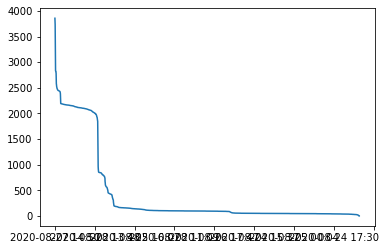

In [118]:
times[0].sort_values(ascending=False).plot()

## Group A : 1분당 최다 접근 기록: 
- 분당 3000회 이상 접근되어짐 (총 7개의 1분간이 존재)
- 시간 순서상 1,2번 시간대와 3~7번 시간대가 연속되는 시간으로 묶임
- Group A-1
    - 1,2번 시간대에는 특정 호스트 혼자 (95% 이상) 접근 
- Group A-2
    - 3~7번 시간대에는 최다 접근 호스트와 그 다음 호스트의 갭이 큼
    - 3~7번 시간대에는 특정 호스트가 50% 이상 접근함
    - 3~7번 시간대에는 접근했던 각각의 다른 호스트 값이 200개가 넘음

In [1]:
result = {}
time_a = []
host = []
for name, group in time_grp.Host:
    if int(len(group)) > 3000:
        print(name + ' : ' + str(len(group)))
        print()
        time_a.append(name)

NameError: name 'time_grp' is not defined

In [133]:
for i in time_a:
    x = df[df['Timestamp'] == i]['Host'].value_counts().head(10)
    y = len(df[df['Timestamp'] == i]['Host'].value_counts())
    print(x)
    print('개별 호스트 유니크 :',y)
    print()

231.211.11.16      3437
16.48.165.221         3
120.134.254.237       3
208.35.252.92         3
245.139.222.202       2
55.41.204.15          2
131.89.184.82         2
229.104.179.29        2
146.138.0.143         2
237.78.137.30         2
Name: Host, dtype: int64
개별 호스트 유니크 : 33

231.211.11.16     3144
55.41.204.15         3
158.80.167.104       3
139.111.27.209       3
189.3.16.156         2
235.36.100.189       2
49.197.205.61        2
131.89.184.82        2
174.177.3.59         2
65.230.189.134       1
Name: Host, dtype: int64
개별 호스트 유니크 : 37

188.45.31.20       1560
73.52.126.133        43
129.236.75.8         43
118.52.128.24        42
183.209.224.212      41
238.60.95.5          41
132.134.0.43         39
35.146.170.79        38
34.121.125.108       38
219.126.10.96        37
Name: Host, dtype: int64
개별 호스트 유니크 : 247

188.45.31.20       1764
155.101.146.48       46
120.207.123.148      46
42.88.127.114        43
84.83.171.161        43
132.134.0.43         42
167.145.154.40     

## Group B : 중간 그룹
- 분당 3000회 이하, 1000회 이상 접근되어짐 (2000회 이상과 큰 차이가 없다.)
- group B-1
    - 분당 개별 호스트가 200개 미만인 경우 (총 9개의 시간이 존재)
    - 분당 최다 접근 호스트와 그 다음으로 접근이 많은 호스트의 차가 1000회 이상 차이남
- group B-2
    - 분당 개별 호스트수가 200개 이상인 경우
    - 다수의 호스트가 분당 40~50번의 접근을 시도한다.
- group B-3
    - 분당 개별 호스트는 200 미만이나 분당최대 호스트와의 차가 1000회 이상 차이나지 않음(2개)
        - 2020-08-27 12:41 : 188.45.31.20 - 720, 178.245.100.17 - 11
        - 2020-08-27 15:59 : 188.45.31.40 - 407, 188.45.31.30 - 305
    

In [40]:
result = {}
time_b = {}
host = []
for name, group in time_grp.Host:
    if (int(len(group)) <= 3000) & (int(len(group)) > 1000):
#         print(name + ' : ' + str(len(group)))
#         print()
        time_b[name] = int(len(group))
time_b = pd.DataFrame.from_dict(time_b, orient='index')
time_b.describe()

,0
count,536.000000
mean,2147.986940
std,175.069198
min,1058.000000
25%,2081.750000
50%,2126.000000
75%,2169.000000
max,2937.000000


<AxesSubplot:>

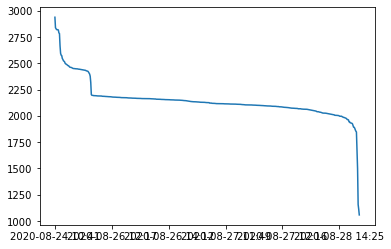

In [41]:
time_b[0].sort_values(ascending=False).plot()

In [47]:
result = {}
for i in time_b[0].sort_values(ascending=False).index:
    x = df[df['Timestamp'] == i]['Host'].value_counts().head(2)
    y = len(df[df['Timestamp'] == i]['Host'].value_counts())
    if y < 200:
        result[i] = x
        print(f'{i}의 개별 호스트 유니크 : {y}')
        print()
result

2020-08-24 10:41의 개별 호스트 유니크 : 14

2020-08-25 10:19의 개별 호스트 유니크 : 34

2020-08-24 10:42의 개별 호스트 유니크 : 19

2020-08-26 17:38의 개별 호스트 유니크 : 79

2020-08-26 17:36의 개별 호스트 유니크 : 75

2020-08-26 17:37의 개별 호스트 유니크 : 79

2020-08-26 17:35의 개별 호스트 유니크 : 78

2020-08-26 17:39의 개별 호스트 유니크 : 72

2020-08-27 12:41의 개별 호스트 유니크 : 186

2020-08-27 15:59의 개별 호스트 유니크 : 80

2020-08-24 16:31의 개별 호스트 유니크 : 33



{'2020-08-24 10:41': 101.224.32.28     2921
 150.145.13.106       2
 Name: Host, dtype: int64,
 '2020-08-25 10:19': 231.211.11.16    2495
 6.231.34.180        3
 Name: Host, dtype: int64,
 '2020-08-24 10:42': 101.224.32.28     2129
 104.112.53.152       2
 Name: Host, dtype: int64,
 '2020-08-26 17:38': 112.112.181.134    1801
 24.81.238.2           4
 Name: Host, dtype: int64,
 '2020-08-26 17:36': 112.112.181.134    1797
 225.167.194.192       3
 Name: Host, dtype: int64,
 '2020-08-26 17:37': 112.112.181.134    1782
 104.249.6.59          3
 Name: Host, dtype: int64,
 '2020-08-26 17:35': 112.112.181.134    1761
 244.196.166.240       4
 Name: Host, dtype: int64,
 '2020-08-26 17:39': 112.112.181.134    1407
 169.153.181.202       4
 Name: Host, dtype: int64,
 '2020-08-27 12:41': 188.45.31.20      720
 178.245.100.17     11
 Name: Host, dtype: int64,
 '2020-08-27 15:59': 188.45.31.40    407
 188.45.31.30    305
 Name: Host, dtype: int64,
 '2020-08-24 16:31': 101.224.32.28      1013
 183.

## Group C : 최소 접근 1분
- 1000회 이하의 기록이 담긴 1분들
- 200회 이하의 접근이 3082번, 1000회 이하의 접근이 3279번이다. 분당 200회 이하의 접근이 전체 데이터의 80% 이상이다.


In [111]:
result = {}
time_c = {}
host = []
for name, group in time_grp.Host:
    if (int(len(group)) <= 1000):
#         print(name + ' : ' + str(len(group)))
#         print()
        time_c[name] = int(len(group))
time_c = pd.DataFrame.from_dict(time_c, orient='index')
time_c.describe()

,0
count,3279.000000
mean,109.845990
std,141.755241
min,1.000000
25%,47.000000
50%,87.000000
75%,103.000000
max,963.000000


In [112]:
time_c[0].sort_values(ascending=False)

2020-08-25 14:41    963
2020-08-27 13:11    947
2020-08-27 15:32    909
2020-08-27 15:33    881
2020-08-27 16:11    874
                   ... 
2020-08-25 00:30      1
2020-08-26 00:30      1
2020-08-24 20:31      1
2020-08-27 00:30      1
2020-08-24 20:30      1
Name: 0, Length: 3279, dtype: int64

In [116]:
3082 / 3822 # 200번 이상 접근한 1분 / 전체 데이터

0.8063840920983778

In [114]:
result = {}
for i in time_c[0].sort_values(ascending=False).index:
    x = df[df['Timestamp'] == i]['Host'].value_counts().head(2)
    y = len(df[df['Timestamp'] == i]['Host'].value_counts())
    if y < 200:
        result[i] = x
        print(f'{i}의 개별 호스트 유니크 : {y}')
        print()
result

2020-08-25 14:41의 개별 호스트 유니크 : 192

2020-08-27 13:11의 개별 호스트 유니크 : 181

2020-08-27 15:32의 개별 호스트 유니크 : 77

2020-08-27 15:33의 개별 호스트 유니크 : 74

2020-08-27 16:11의 개별 호스트 유니크 : 81

2020-08-27 16:57의 개별 호스트 유니크 : 70

2020-08-27 16:19의 개별 호스트 유니크 : 75

2020-08-27 17:06의 개별 호스트 유니크 : 80

2020-08-27 15:40의 개별 호스트 유니크 : 76

2020-08-27 16:44의 개별 호스트 유니크 : 80

2020-08-27 16:37의 개별 호스트 유니크 : 78

2020-08-27 15:34의 개별 호스트 유니크 : 75

2020-08-27 15:37의 개별 호스트 유니크 : 81

2020-08-27 16:39의 개별 호스트 유니크 : 73

2020-08-27 15:38의 개별 호스트 유니크 : 77

2020-08-27 17:04의 개별 호스트 유니크 : 73

2020-08-27 15:30의 개별 호스트 유니크 : 78

2020-08-27 17:05의 개별 호스트 유니크 : 74

2020-08-27 16:43의 개별 호스트 유니크 : 74

2020-08-27 15:36의 개별 호스트 유니크 : 69

2020-08-27 16:36의 개별 호스트 유니크 : 80

2020-08-27 16:38의 개별 호스트 유니크 : 72

2020-08-27 16:58의 개별 호스트 유니크 : 73

2020-08-27 16:12의 개별 호스트 유니크 : 73

2020-08-27 16:22의 개별 호스트 유니크 : 80

2020-08-27 15:58의 개별 호스트 유니크 : 75

2020-08-27 15:31의 개별 호스트 유니크 : 71

2020-08-27 16:07의 개별 호스트 유니크 : 72

2020-08-27 17:07의 

2020-08-25 11:50의 개별 호스트 유니크 : 80

2020-08-25 11:53의 개별 호스트 유니크 : 72

2020-08-26 14:07의 개별 호스트 유니크 : 67

2020-08-25 11:33의 개별 호스트 유니크 : 71

2020-08-25 12:04의 개별 호스트 유니크 : 74

2020-08-25 12:10의 개별 호스트 유니크 : 68

2020-08-25 12:00의 개별 호스트 유니크 : 65

2020-08-26 13:04의 개별 호스트 유니크 : 80

2020-08-25 11:43의 개별 호스트 유니크 : 72

2020-08-25 11:42의 개별 호스트 유니크 : 74

2020-08-26 14:02의 개별 호스트 유니크 : 76

2020-08-26 13:10의 개별 호스트 유니크 : 82

2020-08-26 14:03의 개별 호스트 유니크 : 68

2020-08-26 14:10의 개별 호스트 유니크 : 79

2020-08-25 14:00의 개별 호스트 유니크 : 110

2020-08-26 12:38의 개별 호스트 유니크 : 74

2020-08-26 12:40의 개별 호스트 유니크 : 80

2020-08-26 13:30의 개별 호스트 유니크 : 96

2020-08-26 14:09의 개별 호스트 유니크 : 75

2020-08-25 15:55의 개별 호스트 유니크 : 102

2020-08-26 12:01의 개별 호스트 유니크 : 79

2020-08-25 11:06의 개별 호스트 유니크 : 33

2020-08-25 12:30의 개별 호스트 유니크 : 104

2020-08-24 16:35의 개별 호스트 유니크 : 32

2020-08-26 13:06의 개별 호스트 유니크 : 72

2020-08-25 11:08의 개별 호스트 유니크 : 38

2020-08-26 15:56의 개별 호스트 유니크 : 73

2020-08-26 15:58의 개별 호스트 유니크 : 73

2020-08-25 11:11의

2020-08-25 16:13의 개별 호스트 유니크 : 76

2020-08-25 16:26의 개별 호스트 유니크 : 75

2020-08-25 16:49의 개별 호스트 유니크 : 75

2020-08-25 11:23의 개별 호스트 유니크 : 39

2020-08-25 16:35의 개별 호스트 유니크 : 72

2020-08-25 16:38의 개별 호스트 유니크 : 73

2020-08-25 17:22의 개별 호스트 유니크 : 76

2020-08-25 13:35의 개별 호스트 유니크 : 79

2020-08-25 11:28의 개별 호스트 유니크 : 39

2020-08-25 17:30의 개별 호스트 유니크 : 72

2020-08-25 17:13의 개별 호스트 유니크 : 76

2020-08-25 17:10의 개별 호스트 유니크 : 80

2020-08-25 12:38의 개별 호스트 유니크 : 75

2020-08-25 16:55의 개별 호스트 유니크 : 73

2020-08-25 16:22의 개별 호스트 유니크 : 70

2020-08-25 16:53의 개별 호스트 유니크 : 69

2020-08-25 16:52의 개별 호스트 유니크 : 72

2020-08-25 16:23의 개별 호스트 유니크 : 72

2020-08-25 16:47의 개별 호스트 유니크 : 64

2020-08-25 17:28의 개별 호스트 유니크 : 69

2020-08-25 17:01의 개별 호스트 유니크 : 78

2020-08-25 14:02의 개별 호스트 유니크 : 69

2020-08-25 13:33의 개별 호스트 유니크 : 70

2020-08-25 16:06의 개별 호스트 유니크 : 71

2020-08-25 11:25의 개별 호스트 유니크 : 37

2020-08-25 16:16의 개별 호스트 유니크 : 69

2020-08-26 14:31의 개별 호스트 유니크 : 40

2020-08-25 13:34의 개별 호스트 유니크 : 70

2020-08-25 11:15의 개별

2020-08-27 19:13의 개별 호스트 유니크 : 75

2020-08-26 15:05의 개별 호스트 유니크 : 34

2020-08-26 10:49의 개별 호스트 유니크 : 37

2020-08-25 15:08의 개별 호스트 유니크 : 39

2020-08-25 18:50의 개별 호스트 유니크 : 73

2020-08-25 18:52의 개별 호스트 유니크 : 75

2020-08-27 19:40의 개별 호스트 유니크 : 78

2020-08-26 18:31의 개별 호스트 유니크 : 80

2020-08-26 18:35의 개별 호스트 유니크 : 75

2020-08-28 16:24의 개별 호스트 유니크 : 76

2020-08-27 18:35의 개별 호스트 유니크 : 74

2020-08-28 16:51의 개별 호스트 유니크 : 79

2020-08-25 18:37의 개별 호스트 유니크 : 71

2020-08-26 15:10의 개별 호스트 유니크 : 35

2020-08-25 14:32의 개별 호스트 유니크 : 40

2020-08-25 15:04의 개별 호스트 유니크 : 34

2020-08-25 17:59의 개별 호스트 유니크 : 82

2020-08-27 11:39의 개별 호스트 유니크 : 73

2020-08-27 17:54의 개별 호스트 유니크 : 72

2020-08-26 11:05의 개별 호스트 유니크 : 36

2020-08-28 16:01의 개별 호스트 유니크 : 69

2020-08-25 19:40의 개별 호스트 유니크 : 76

2020-08-26 15:17의 개별 호스트 유니크 : 37

2020-08-25 18:40의 개별 호스트 유니크 : 79

2020-08-27 19:43의 개별 호스트 유니크 : 72

2020-08-26 19:44의 개별 호스트 유니크 : 74

2020-08-25 18:03의 개별 호스트 유니크 : 71

2020-08-27 19:07의 개별 호스트 유니크 : 83

2020-08-26 11:10의 개별

2020-08-26 19:38의 개별 호스트 유니크 : 72

2020-08-28 17:37의 개별 호스트 유니크 : 77

2020-08-27 17:24의 개별 호스트 유니크 : 80

2020-08-26 18:38의 개별 호스트 유니크 : 74

2020-08-26 13:33의 개별 호스트 유니크 : 70

2020-08-26 18:29의 개별 호스트 유니크 : 68

2020-08-28 15:32의 개별 호스트 유니크 : 73

2020-08-28 15:31의 개별 호스트 유니크 : 67

2020-08-27 16:46의 개별 호스트 유니크 : 76

2020-08-26 19:42의 개별 호스트 유니크 : 73

2020-08-25 17:52의 개별 호스트 유니크 : 72

2020-08-25 18:04의 개별 호스트 유니크 : 75

2020-08-26 18:21의 개별 호스트 유니크 : 77

2020-08-28 15:03의 개별 호스트 유니크 : 74

2020-08-28 11:11의 개별 호스트 유니크 : 71

2020-08-28 17:20의 개별 호스트 유니크 : 67

2020-08-28 16:26의 개별 호스트 유니크 : 74

2020-08-28 14:33의 개별 호스트 유니크 : 75

2020-08-27 19:04의 개별 호스트 유니크 : 79

2020-08-27 19:24의 개별 호스트 유니크 : 79

2020-08-27 19:23의 개별 호스트 유니크 : 76

2020-08-26 17:28의 개별 호스트 유니크 : 71

2020-08-26 17:33의 개별 호스트 유니크 : 79

2020-08-28 18:13의 개별 호스트 유니크 : 71

2020-08-28 11:09의 개별 호스트 유니크 : 73

2020-08-27 18:15의 개별 호스트 유니크 : 76

2020-08-27 18:27의 개별 호스트 유니크 : 80

2020-08-25 18:54의 개별 호스트 유니크 : 74

2020-08-27 12:32의 개별

2020-08-25 19:43의 개별 호스트 유니크 : 74

2020-08-27 19:50의 개별 호스트 유니크 : 76

2020-08-27 15:56의 개별 호스트 유니크 : 77

2020-08-27 19:53의 개별 호스트 유니크 : 76

2020-08-28 12:55의 개별 호스트 유니크 : 67

2020-08-27 19:58의 개별 호스트 유니크 : 73

2020-08-27 19:59의 개별 호스트 유니크 : 61

2020-08-26 18:09의 개별 호스트 유니크 : 69

2020-08-25 19:30의 개별 호스트 유니크 : 76

2020-08-26 18:32의 개별 호스트 유니크 : 72

2020-08-28 12:59의 개별 호스트 유니크 : 73

2020-08-26 18:12의 개별 호스트 유니크 : 62

2020-08-28 17:18의 개별 호스트 유니크 : 71

2020-08-27 19:21의 개별 호스트 유니크 : 75

2020-08-28 12:47의 개별 호스트 유니크 : 79

2020-08-27 17:18의 개별 호스트 유니크 : 72

2020-08-27 17:38의 개별 호스트 유니크 : 69

2020-08-27 17:40의 개별 호스트 유니크 : 70

2020-08-27 17:41의 개별 호스트 유니크 : 72

2020-08-27 17:42의 개별 호스트 유니크 : 72

2020-08-27 17:52의 개별 호스트 유니크 : 73

2020-08-27 18:01의 개별 호스트 유니크 : 67

2020-08-27 17:11의 개별 호스트 유니크 : 73

2020-08-27 18:09의 개별 호스트 유니크 : 72

2020-08-27 18:13의 개별 호스트 유니크 : 75

2020-08-27 18:18의 개별 호스트 유니크 : 69

2020-08-27 18:19의 개별 호스트 유니크 : 67

2020-08-28 15:08의 개별 호스트 유니크 : 71

2020-08-26 13:40의 개별

2020-08-27 18:42의 개별 호스트 유니크 : 72

2020-08-26 17:58의 개별 호스트 유니크 : 64

2020-08-28 17:50의 개별 호스트 유니크 : 71

2020-08-28 11:33의 개별 호스트 유니크 : 69

2020-08-25 18:29의 개별 호스트 유니크 : 71

2020-08-26 19:28의 개별 호스트 유니크 : 68

2020-08-25 19:31의 개별 호스트 유니크 : 67

2020-08-28 16:30의 개별 호스트 유니크 : 65

2020-08-28 10:09의 개별 호스트 유니크 : 67

2020-08-26 19:35의 개별 호스트 유니크 : 66

2020-08-26 18:30의 개별 호스트 유니크 : 69

2020-08-25 19:24의 개별 호스트 유니크 : 71

2020-08-28 14:08의 개별 호스트 유니크 : 71

2020-08-25 19:22의 개별 호스트 유니크 : 71

2020-08-28 16:04의 개별 호스트 유니크 : 70

2020-08-28 14:07의 개별 호스트 유니크 : 72

2020-08-27 12:02의 개별 호스트 유니크 : 73

2020-08-26 17:47의 개별 호스트 유니크 : 70

2020-08-25 19:02의 개별 호스트 유니크 : 68

2020-08-25 18:15의 개별 호스트 유니크 : 69

2020-08-28 16:38의 개별 호스트 유니크 : 69

2020-08-28 18:32의 개별 호스트 유니크 : 75

2020-08-25 18:42의 개별 호스트 유니크 : 71

2020-08-28 18:25의 개별 호스트 유니크 : 67

2020-08-28 13:12의 개별 호스트 유니크 : 69

2020-08-28 10:11의 개별 호스트 유니크 : 74

2020-08-28 18:14의 개별 호스트 유니크 : 66

2020-08-28 14:39의 개별 호스트 유니크 : 72

2020-08-27 18:33의 개별

2020-08-28 16:31의 개별 호스트 유니크 : 63

2020-08-24 15:32의 개별 호스트 유니크 : 33

2020-08-27 19:44의 개별 호스트 유니크 : 71

2020-08-24 15:56의 개별 호스트 유니크 : 34

2020-08-24 14:56의 개별 호스트 유니크 : 34

2020-08-27 14:55의 개별 호스트 유니크 : 66

2020-08-24 14:58의 개별 호스트 유니크 : 38

2020-08-24 16:29의 개별 호스트 유니크 : 29

2020-08-24 15:46의 개별 호스트 유니크 : 33

2020-08-24 13:40의 개별 호스트 유니크 : 34

2020-08-24 14:02의 개별 호스트 유니크 : 28

2020-08-24 13:44의 개별 호스트 유니크 : 31

2020-08-24 15:11의 개별 호스트 유니크 : 34

2020-08-24 14:43의 개별 호스트 유니크 : 38

2020-08-24 13:46의 개별 호스트 유니크 : 32

2020-08-24 15:39의 개별 호스트 유니크 : 35

2020-08-24 10:20의 개별 호스트 유니크 : 24

2020-08-24 15:50의 개별 호스트 유니크 : 35

2020-08-24 13:27의 개별 호스트 유니크 : 31

2020-08-24 15:57의 개별 호스트 유니크 : 30

2020-08-24 15:59의 개별 호스트 유니크 : 32

2020-08-24 15:52의 개별 호스트 유니크 : 30

2020-08-24 11:24의 개별 호스트 유니크 : 31

2020-08-24 13:48의 개별 호스트 유니크 : 31

2020-08-24 13:23의 개별 호스트 유니크 : 35

2020-08-24 13:45의 개별 호스트 유니크 : 28

2020-08-24 16:22의 개별 호스트 유니크 : 36

2020-08-24 14:21의 개별 호스트 유니크 : 28

2020-08-24 15:58의 개별

KeyboardInterrupt: 

# Mozilla와 Opera를 제외한 UA

In [ ]:
no_mozilla.loc[~no_mozilla['UA'].str.contains('Opera')]['UA'].unique()